In [1]:
import pandas as pd 
import numpy as np 
import spacy 
import seaborn as sns 
import re 
import nltk 
import warnings 

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import KBinsDiscretizer 
from sklearn.decomposition import PCA 
from sklearn import set_config 
from nltk.sentiment import SentimentIntensityAnalyzer

from plotly import express as px 
from wordcloud import WordCloud
from matplotlib import pyplot as plt 
from nltk.corpus import stopwords
from IPython.display import display 
from tqdm import tqdm 

from gensim.utils import simple_preprocess
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models import Word2Vec 

sns.set_style('darkgrid')
set_config(display = 'diagram')
warnings.simplefilter('ignore')
nlp = spacy.load('en_core_web_lg')

In [2]:
DATA_PATH = '../ds/PlaceRecommender.csv'
recommender = pd.read_csv(DATA_PATH)

print('Average number of reviews per place  = {}\n'.format(recommender.reviews.nunique()/recommender.place.nunique())) 
print('The total number of unique reviews are: {}\n'.format(recommender.reviews.nunique()))

print('That means that there are {} duplicate rows\n'.format(len(recommender) - recommender.reviews.nunique()))

#Eliminating duplicate rows... 
recommender = recommender.drop_duplicates(subset = 'reviews')
display(recommender) 

print('\nTotal number of unique places are {} and total number of unique reviews are {}\n'.format(recommender.place.nunique(), recommender.reviews.nunique()))
print('Average number of reviews per place  = {}\n'.format(recommender.reviews.nunique()/recommender.place.nunique())) 

Average number of reviews per place  = 27.136005726556906

The total number of unique reviews are: 37909

That means that there are 8930 duplicate rows



,place,reviews,rating,location,description,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Rai Praveen Mahal,Good for a touch and go during your fort vist,3.5,jhansi,Rai Praveen Mahal upholds the historical lege...,25.4486,78.5696,India,IN,Uttar Pradesh,NaN,507000.0,507000.0
1,Rai Praveen Mahal,"This is within the Orchha fort complex, it is ...",3.5,jhansi,Rai Praveen Mahal upholds the historical lege...,25.4486,78.5696,India,IN,Uttar Pradesh,NaN,507000.0,507000.0
2,Rai Praveen Mahal,More of a ruin,3.5,jhansi,Rai Praveen Mahal upholds the historical lege...,25.4486,78.5696,India,IN,Uttar Pradesh,NaN,507000.0,507000.0
3,Rai Praveen Mahal,The place is not exactly a mahal and is largel...,3.5,jhansi,Rai Praveen Mahal upholds the historical lege...,25.4486,78.5696,India,IN,Uttar Pradesh,NaN,507000.0,507000.0
4,Rai Praveen Mahal,Poorly Managed,3.5,jhansi,Rai Praveen Mahal upholds the historical lege...,25.4486,78.5696,India,IN,Uttar Pradesh,NaN,507000.0,507000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46833,Bura Chapori Wildlife Sanctuary,"Plumbious water red star, White ramped shama, ...",4.5,tezpur,"Bura Chapori Wildlife Sanctuary, located arou...",26.6338,92.8000,India,IN,Assam,NaN,58851.0,58851.0
46834,Bura Chapori Wildlife Sanctuary,"Green pigeon (small), Pin tail Green pigeon, e...",4.5,tezpur,"Bura Chapori Wildlife Sanctuary, located arou...",26.6338,92.8000,India,IN,Assam,NaN,58851.0,58851.0
46836,Bura Chapori Wildlife Sanctuary,this wildlife sanctuary is very near to Tezpur...,4.5,tezpur,"Bura Chapori Wildlife Sanctuary, located arou...",26.6338,92.8000,India,IN,Assam,NaN,58851.0,58851.0
46837,Bura Chapori Wildlife Sanctuary,On the bank of Brahmaputra it is excellent ...,4.5,tezpur,"Bura Chapori Wildlife Sanctuary, located arou...",26.6338,92.8000,India,IN,Assam,NaN,58851.0,58851.0



Total number of unique places are 1397 and total number of unique reviews are 37909

Average number of reviews per place  = 27.136005726556906



In [3]:
def make_dataset():
    places = list(recommender.place.unique())
    raw_dataframe = {
        'city':[], 
        'reviews':[], 
        'description':[], 
        'rating':[],
        'latitude':[], 
        'longitude':[], 
        'city':[], 
        'population':[], 
        'place':[], 
    }

    #One record for one place 
    for place in tqdm(places):
        records = recommender.loc[
            recommender.place == place, :
        ]

        raw_dataframe['place'].append(place) 
        raw_dataframe['reviews'].append(" ".join(list(records.reviews.unique()))) 

        raw_dataframe['rating'].append(
            np.mean(records.rating)
        )

        raw_dataframe['city'].append(
            list(
                records.location.unique()
            )[0]
        )

        raw_dataframe['description'].append(
            list(
                records.description.unique()
            )[0]
        )

        raw_dataframe['population'].append(
            list(
                records.population.unique()
            )[0]
        )

        raw_dataframe['latitude'].append(
            list(
                records.lat.unique()
            )[0]
        )

        raw_dataframe['longitude'].append(
            list(
                records.lng.unique()
            )[0]
        )

    return raw_dataframe

reviews = pd.DataFrame(make_dataset()) 


100%|██████████| 1397/1397 [00:04<00:00, 333.87it/s]


In [5]:
# Designing a custom transformer 
class RemoveStopWords(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.stopwords = stopwords.words('english')

    def clean_text(self, text: str):
        text = text.lower()
        for word in self.stopwords:
            pattern = re.compile(f' {word.lower()} ')
            text = re.sub(pattern, ' ', text)
        
        place = re.compile(r' place ')
        one = re.compile(r' one ')
        good = re.compile(r' good ')

        text = re.sub(one, ' ', text)
        text = re.sub(place, ' ', text)
        text = re.sub(good, ' ', text)
        return text 

            
    def fit(self, X, y = None):
        X_ = pd.DataFrame(X)
        self.cleaned_text = X_.iloc[:, 0].apply(self.clean_text)
        return self 
    
    def transform(self, X, y = None):
        return self.cleaned_text.values
    

# Making a reviews + description column so we can better match user descriptions with the location of visit. 
reviews['describer'] = reviews['reviews'] + reviews['description']

#Cleaning the describer column 
remover = RemoveStopWords()
reviews['describer'] = remover.fit_transform(reviews.describer)

display(reviews)



,city,reviews,description,rating,latitude,longitude,population,place,describer
0,jhansi,Good for a touch and go during your fort vist ...,Rai Praveen Mahal upholds the historical lege...,3.500000,25.4486,78.5696,507000.0,Rai Praveen Mahal,good touch go fort vist within orchha fort com...
1,jhansi,Great view This was good place. Awesome view ...,Barua Sagar in the Jhansi district of Uttar P...,3.500000,25.4486,78.5696,507000.0,Barua Sagar,great view place. awesome view bank river. vi...
2,jhansi,Very good place for picnic. It was a very good...,"Parichha Dam, a human-made reservoir is built...",4.000000,25.4486,78.5696,507000.0,Parichha Dam,"very picnic. visit, picnic spot. nice clean pl..."
3,jhansi,Located in Garden below the fort Located in a ...,"Rani Lakshmi Bai Park located in Jhansi, Utta...",4.444444,25.4486,78.5696,507000.0,Rani Lakshmi Bai Park,located garden fort located clean garden fort....
4,jhansi,River View & Photography Orchha Wildlife Sanct...,"Orchha Wildlife Sanctuary located in Orchha, ...",3.500000,25.4486,78.5696,507000.0,Orchha Wildlife Sanctuary,river view & photography orchha wildlife sanct...
...,...,...,...,...,...,...,...,...,...
1392,tezpur,Tejpur is famous for its gardens and this is o...,"Also known as Cole Park, Chitralekha Udyan in...",4.000000,26.6338,92.8000,58851.0,Chitralekha Udyan,tejpur famous gardens well maintained parks . ...
1393,tezpur,a holy place of 'Vairav' calm and quite. the t...,The Mahabhairab Temple in the north of Tezpur...,4.000000,26.6338,92.8000,58851.0,Mahabhairab Temple,a holy 'vairav' calm quite. temple situated he...
1394,tezpur,A small lake close to market place. Surrounded...,"Padum Pukhuri, which translates to Lotus Pond...",3.500000,26.6338,92.8000,58851.0,Padum Pukhuri,a small lake close market place. surrounded sm...
1395,tezpur,Amazing architectural marvel More than 3 km lo...,Over 3 kilometres long and joining the southe...,4.000000,26.6338,92.8000,58851.0,Kolia Bhomora Setu,amazing architectural marvel 3 km long bridge ...


In [6]:
# Generating wordcloud 
# cloud = WordCloud()
# bag = CountVectorizer(ngram_range=(1, 3))
# bag.fit(reviews.describer)
# word_counts = bag.transform(reviews.describer)
# frequency_map = dict(zip(bag.get_feature_names_out(), word_counts.toarray().sum(axis=0)))
# img = cloud.generate_from_frequencies(frequency_map)
# plt.imshow(img)
# plt.show()

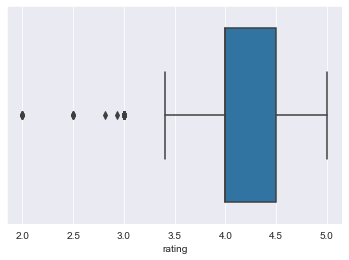

In [7]:
# Unique ratings 
reviews.rating.unique()

sns.boxplot(x = 'rating', data = reviews)
plt.show()



In [8]:
# Clustering our ratings so we can make rating bins 

discretizer = KBinsDiscretizer(n_bins = 3, encode = 'ordinal', strategy = 'kmeans')
reviews['rating_cls'] = discretizer.fit_transform(reviews.rating.values.reshape(-1, 1))
discretizer.bin_edges_

array([array([2.        , 3.33982925, 4.21527114, 5.        ])],
      dtype=object)

In [9]:
# Checking word counts wise ratings 

display(reviews) 

print(reviews.rating_cls.value_counts(normalize = True)*100) 

,city,reviews,description,rating,latitude,longitude,population,place,describer,rating_cls
0,jhansi,Good for a touch and go during your fort vist ...,Rai Praveen Mahal upholds the historical lege...,3.500000,25.4486,78.5696,507000.0,Rai Praveen Mahal,good touch go fort vist within orchha fort com...,1.0
1,jhansi,Great view This was good place. Awesome view ...,Barua Sagar in the Jhansi district of Uttar P...,3.500000,25.4486,78.5696,507000.0,Barua Sagar,great view place. awesome view bank river. vi...,1.0
2,jhansi,Very good place for picnic. It was a very good...,"Parichha Dam, a human-made reservoir is built...",4.000000,25.4486,78.5696,507000.0,Parichha Dam,"very picnic. visit, picnic spot. nice clean pl...",1.0
3,jhansi,Located in Garden below the fort Located in a ...,"Rani Lakshmi Bai Park located in Jhansi, Utta...",4.444444,25.4486,78.5696,507000.0,Rani Lakshmi Bai Park,located garden fort located clean garden fort....,2.0
4,jhansi,River View & Photography Orchha Wildlife Sanct...,"Orchha Wildlife Sanctuary located in Orchha, ...",3.500000,25.4486,78.5696,507000.0,Orchha Wildlife Sanctuary,river view & photography orchha wildlife sanct...,1.0
...,...,...,...,...,...,...,...,...,...,...
1392,tezpur,Tejpur is famous for its gardens and this is o...,"Also known as Cole Park, Chitralekha Udyan in...",4.000000,26.6338,92.8000,58851.0,Chitralekha Udyan,tejpur famous gardens well maintained parks . ...,1.0
1393,tezpur,a holy place of 'Vairav' calm and quite. the t...,The Mahabhairab Temple in the north of Tezpur...,4.000000,26.6338,92.8000,58851.0,Mahabhairab Temple,a holy 'vairav' calm quite. temple situated he...,1.0
1394,tezpur,A small lake close to market place. Surrounded...,"Padum Pukhuri, which translates to Lotus Pond...",3.500000,26.6338,92.8000,58851.0,Padum Pukhuri,a small lake close market place. surrounded sm...,1.0
1395,tezpur,Amazing architectural marvel More than 3 km lo...,Over 3 kilometres long and joining the southe...,4.000000,26.6338,92.8000,58851.0,Kolia Bhomora Setu,amazing architectural marvel 3 km long bridge ...,1.0


1.0    54.617037
2.0    42.090193
0.0     3.292770
Name: rating_cls, dtype: float64


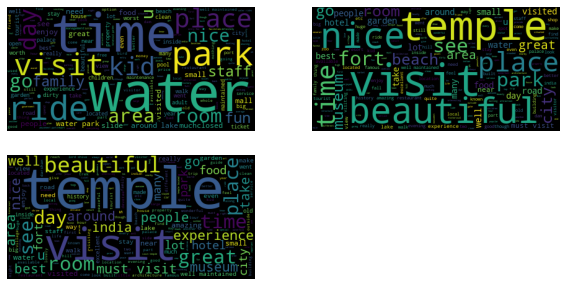

In [10]:
# Studying the vocabulary of the low, med, and high rated corpii
low_rated_df, med_rated_df, high_rated_df = reviews.loc[reviews.rating_cls == 0, :].describer, reviews.loc[reviews.rating_cls == 1, :].describer, reviews.loc[reviews.rating_cls == 2, :].describer
low_corpus, med_corpus, high_corpus = " ".join(low_rated_df.values.tolist()), " ".join(med_rated_df.values.tolist()), " ".join(high_rated_df.values.tolist())

# Generating different clouds 

low_cloud, med_cloud, high_cloud = WordCloud(), WordCloud(), WordCloud()
low_img = low_cloud.generate(low_corpus)
med_img = med_cloud.generate(med_corpus)
high_img = high_cloud.generate(high_corpus)


fig = plt.figure(figsize = (10, 5))
fig.add_subplot(2, 2, 1)
plt.imshow(low_img)
plt.axis('off')
fig.add_subplot(2, 2, 2)
plt.imshow(med_img)
plt.axis('off')
fig.add_subplot(2, 2, 3)
plt.imshow(high_img)
plt.axis('off')
plt.show()

In [11]:
pre_corpus = ".".join(reviews.describer.values.tolist())
sentences = sent_tokenize(pre_corpus)

corpus = []
for sent in sentences: 
    corpus.append(
        simple_preprocess(
            sent
        )
    )

corpus 


[['good',
  'touch',
  'go',
  'fort',
  'vist',
  'within',
  'orchha',
  'fort',
  'complex',
  'best',
  'condition',
  'hurt',
  'touch',
  'go',
  'trip',
  'fort',
  'ruin',
  'exactly',
  'mahal',
  'largely',
  'ruins',
  'story',
  'rai',
  'praveen',
  'courtesan',
  'interesting'],
 ['poorly', 'managed', 'renowned', 'singer', 'dancer', 'bundela', 'era'],
 ['sad', 'state', 'today', 'needs', 'maintenance'],
 ['worth',
  'spending',
  'much',
  'time',
  'badly',
  'neglected',
  'sight',
  'orchha',
  'rai',
  'praveen',
  'history',
  'bundela',
  'dynasty',
  'tells',
  'us',
  'highly',
  'honored',
  'lady',
  'helped',
  'save',
  'dynasty',
  'wrath',
  'moghul',
  'king',
  'akbar'],
 ['learned',
  'woman',
  'also',
  'well',
  'known',
  'indian',
  'classical',
  'dancer',
  'singer',
  'high',
  'repute'],
 ['times', 'got', 'high', 'esteem', 'love', 'price'],
 ['captioned',
  'palace',
  'built',
  'order',
  'king',
  'honor',
  'upon',
  'saving',
  'state',
  'qu

In [12]:
model = Word2Vec(
    window = 10, 
    min_count = 2, 
    epochs = 9, 
    vector_size=200

)

model.build_vocab(corpus, progress_per = 100)
model.train(corpus, epochs = model.epochs, total_examples = model.corpus_count)


(5114837, 5472531)

In [13]:
class ColumnVectorizer(BaseEstimator, TransformerMixin):

    def __init__(self, model = model):
        self.__name = 'column-vectorizer'
        self.model = model 

    def vectorize_sent(self, text):
        words = simple_preprocess(text)
        vector = np.zeros((200, ))

        for word in words:
            try:
                vector += self.model.wv[word]
            except Exception as e:
                pass 

        return vector
    
    def fit(self, X, y = None):
        return self 
    
    def transform(self, X, y = None):
        X_ = pd.DataFrame(X)
        X_.iloc[:, 0] = X_.iloc[:, 0].apply(self.vectorize_sent)
        sentences = X_.values 

        matrix = []
        for sent in sentences: 
            matrix.append(sent[0])

        field = np.array(matrix)

        return field 
    


In [26]:
vec = ColumnVectorizer(model=model)
df_vectors = vec.fit_transform(reviews.describer)

In [39]:
pca = PCA(n_components=3)
x = pca.fit_transform(df)
y = reviews.rating_cls

px.scatter_3d(x = x[:, 0], y = x[:, 1], z = x[:, 2], color = y)

ValueError: could not convert string to float: 'Rai Praveen Mahal'

In [ ]:
def recommend(description, location, dest, relevance):
    words = word_tokenize(description)
    vector = 0 
    for word in words: 
        try:
            vector += model.wv[word]
        except Exception as e:
            pass 

    

    return 

In [ ]:
a = "Hello I am a virgin"
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(a)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [ ]:
reviews['complete_description'] = reviews.reviews + reviews.description 

def get_sentiment(sentences):
    scores = {
        'neg':[], 
        'neu':[], 
        'pos':[], 
        'compound':[], 
    }
    
    for sentence in sentences: 
        polarity = sid.polarity_scores(sentence)
        scores['neg'].append(polarity['neg']) 
        scores['neu'].append(polarity['neu'])
        scores['pos'].append(polarity['pos'])
        scores['compound'].append(polarity['compound'])
    return scores 

desc = reviews.complete_description.values 

scores = get_sentiment(desc)


In [ ]:
df = pd.concat([reviews, pd.DataFrame(scores)], axis = 1)  

In [ ]:
display(df)

,city,reviews,description,rating,latitude,longitude,population,place,describer,rating_cls,complete_description,neg,neu,pos,compound
0,jhansi,Good for a touch and go during your fort vist ...,Rai Praveen Mahal upholds the historical lege...,3.500000,25.4486,78.5696,507000.0,Rai Praveen Mahal,good touch go fort vist within orchha fort com...,1.0,Good for a touch and go during your fort vist ...,0.080,0.778,0.142,0.9957
1,jhansi,Great view This was good place. Awesome view ...,Barua Sagar in the Jhansi district of Uttar P...,3.500000,25.4486,78.5696,507000.0,Barua Sagar,great view place. awesome view bank river. vi...,1.0,Great view This was good place. Awesome view ...,0.030,0.766,0.204,0.9981
2,jhansi,Very good place for picnic. It was a very good...,"Parichha Dam, a human-made reservoir is built...",4.000000,25.4486,78.5696,507000.0,Parichha Dam,"very picnic. visit, picnic spot. nice clean pl...",1.0,Very good place for picnic. It was a very good...,0.007,0.765,0.228,0.9979
3,jhansi,Located in Garden below the fort Located in a ...,"Rani Lakshmi Bai Park located in Jhansi, Utta...",4.444444,25.4486,78.5696,507000.0,Rani Lakshmi Bai Park,located garden fort located clean garden fort....,2.0,Located in Garden below the fort Located in a ...,0.033,0.720,0.246,1.0000
4,jhansi,River View & Photography Orchha Wildlife Sanct...,"Orchha Wildlife Sanctuary located in Orchha, ...",3.500000,25.4486,78.5696,507000.0,Orchha Wildlife Sanctuary,river view & photography orchha wildlife sanct...,1.0,River View & Photography Orchha Wildlife Sanct...,0.037,0.729,0.234,0.9993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1392,tezpur,Tejpur is famous for its gardens and this is o...,"Also known as Cole Park, Chitralekha Udyan in...",4.000000,26.6338,92.8000,58851.0,Chitralekha Udyan,tejpur famous gardens well maintained parks . ...,1.0,Tejpur is famous for its gardens and this is o...,0.005,0.817,0.178,0.9990
1393,tezpur,a holy place of 'Vairav' calm and quite. the t...,The Mahabhairab Temple in the north of Tezpur...,4.000000,26.6338,92.8000,58851.0,Mahabhairab Temple,a holy 'vairav' calm quite. temple situated he...,1.0,a holy place of 'Vairav' calm and quite. the t...,0.009,0.778,0.213,0.9992
1394,tezpur,A small lake close to market place. Surrounded...,"Padum Pukhuri, which translates to Lotus Pond...",3.500000,26.6338,92.8000,58851.0,Padum Pukhuri,a small lake close market place. surrounded sm...,1.0,A small lake close to market place. Surrounded...,0.017,0.798,0.185,0.9972
1395,tezpur,Amazing architectural marvel More than 3 km lo...,Over 3 kilometres long and joining the southe...,4.000000,26.6338,92.8000,58851.0,Kolia Bhomora Setu,amazing architectural marvel 3 km long bridge ...,1.0,Amazing architectural marvel More than 3 km lo...,0.024,0.827,0.149,0.9968


In [40]:
review_sentiments = pd.DataFrame(get_sentiment(recommender.reviews.values)) 


In [41]:
pd.concat([recommender, review_sentiments], axis = 1)

,place,reviews,rating,location,description,lat,lng,country,iso2,admin_name,capital,population,population_proper,neg,neu,pos,compound
0,Rai Praveen Mahal,Good for a touch and go during your fort vist,3.5,jhansi,Rai Praveen Mahal upholds the historical lege...,25.4486,78.5696,India,IN,Uttar Pradesh,NaN,507000.0,507000.0,0.000,0.734,0.266,0.4404
1,Rai Praveen Mahal,"This is within the Orchha fort complex, it is ...",3.5,jhansi,Rai Praveen Mahal upholds the historical lege...,25.4486,78.5696,India,IN,Uttar Pradesh,NaN,507000.0,507000.0,0.069,0.816,0.115,0.3570
2,Rai Praveen Mahal,More of a ruin,3.5,jhansi,Rai Praveen Mahal upholds the historical lege...,25.4486,78.5696,India,IN,Uttar Pradesh,NaN,507000.0,507000.0,0.671,0.329,0.000,-0.6222
3,Rai Praveen Mahal,The place is not exactly a mahal and is largel...,3.5,jhansi,Rai Praveen Mahal upholds the historical lege...,25.4486,78.5696,India,IN,Uttar Pradesh,NaN,507000.0,507000.0,0.083,0.766,0.151,0.3818
4,Rai Praveen Mahal,Poorly Managed,3.5,jhansi,Rai Praveen Mahal upholds the historical lege...,25.4486,78.5696,India,IN,Uttar Pradesh,NaN,507000.0,507000.0,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.366,0.634,0.8251
37826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,1.000,0.000,0.0000
37840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.339,0.661,0.5994
37846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.789,0.211,0.8316


In [42]:
cols = list(recommender.columns) + list(review_sentiments.columns)

df = pd.DataFrame(np.hstack((recommender.values, review_sentiments.values)), columns = cols) 

In [43]:
import pickle 
with open('word2vec.pkl', 'wb') as f:
    pickle.dump(model, f)



In [93]:
df.to_csv('../ds/dataset.csv')

In [36]:
np.hstack((reviews.place.values.reshape(-1, 1), df_vectors))

array([['Rai Praveen Mahal', 149.23224390140967, 16.92938763112761, ...,
        -85.51265547532239, -10.036119268836046, 89.08376159967156],
       ['Barua Sagar', 106.20005383575335, -29.89372840814758, ...,
        -60.80511572910473, -10.005278327618726, -0.18729320168495178],
       ['Parichha Dam', 82.99597769789398, -32.88664570637047, ...,
        -40.53642394207418, -3.9979269096511416, -35.031115023070015],
       ...,
       ['Padum Pukhuri', 83.15216270275414, -27.440861774608493, ...,
        -47.593838351778686, 0.5431174335535616, -17.913556869723834],
       ['Kolia Bhomora Setu', 124.02008237689734, 5.784609710564837, ...,
        -49.00973635097034, 6.274074905319139, 67.06596650945721],
       ['Bura Chapori Wildlife Sanctuary', 119.52285754412878,
        -7.035686118062586, ..., -49.5035778323072, 43.61957177182194,
        -41.59391010977561]], dtype=object)

In [37]:
matchers = pd.DataFrame(
    np.hstack(
        (reviews.place.values.reshape(-1, 1) , df_vectors)
    ), 
    columns=['place'] + list(range(200))
)

matchers.to_csv('../ds/descriptions.csv')

In [29]:
class NLPVectorizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, model = model):
        self.__name = 'column-vectorizer'
        self.model = model 

    def vectorize_sent(self, text):
        return nlp(u'{}'.format(text)).vector
    
    def fit(self, X, y = None):
        return self 
    
    def transform(self, X, y = None):
        X_ = pd.DataFrame(X)
        X_.iloc[:, 0] = X_.iloc[:, 0].apply(self.vectorize_sent)
        sentences = X_.values 

        matrix = []
        for sent in sentences: 
            matrix.append(sent[0])

        field = np.array(matrix)

        return field 
    

vectorizer = NLPVectorizer()
vectorizer.fit(recommender.reviews)

NLPVectorizer()

In [30]:
description  = vectorizer.transform(reviews.description)

In [48]:
descriptions = pd.DataFrame(np.hstack((reviews.place.values.reshape(-1, 1), description)), columns = ['place'] + list(range(300))) 
descriptions.to_csv('../ds/nlp_descriptions.csv', index = False)

In [117]:
vectorizer.fit(recommender.reviews)
review_array = vectorizer.transform(reviews.reviews)
reviews = pd.DataFrame(
    np.hstack(
        (reviews.place.values, review_array)
    ), 
    columns= ['place'] + list(range(300))
)
reviews

In [110]:
np.array(['place'] + list(range(300))).shape

(301,)

In [114]:
(38888*28/1390)/60

13.055923261390888

In [47]:
reviews.to_csv('../ds/all_review.csv', index = False)